In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# EDA

In [2]:
X = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
y = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
X.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [3]:
X.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [4]:
missing_per_column = X.isna().sum()
print(missing_per_column)

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64


Distributions

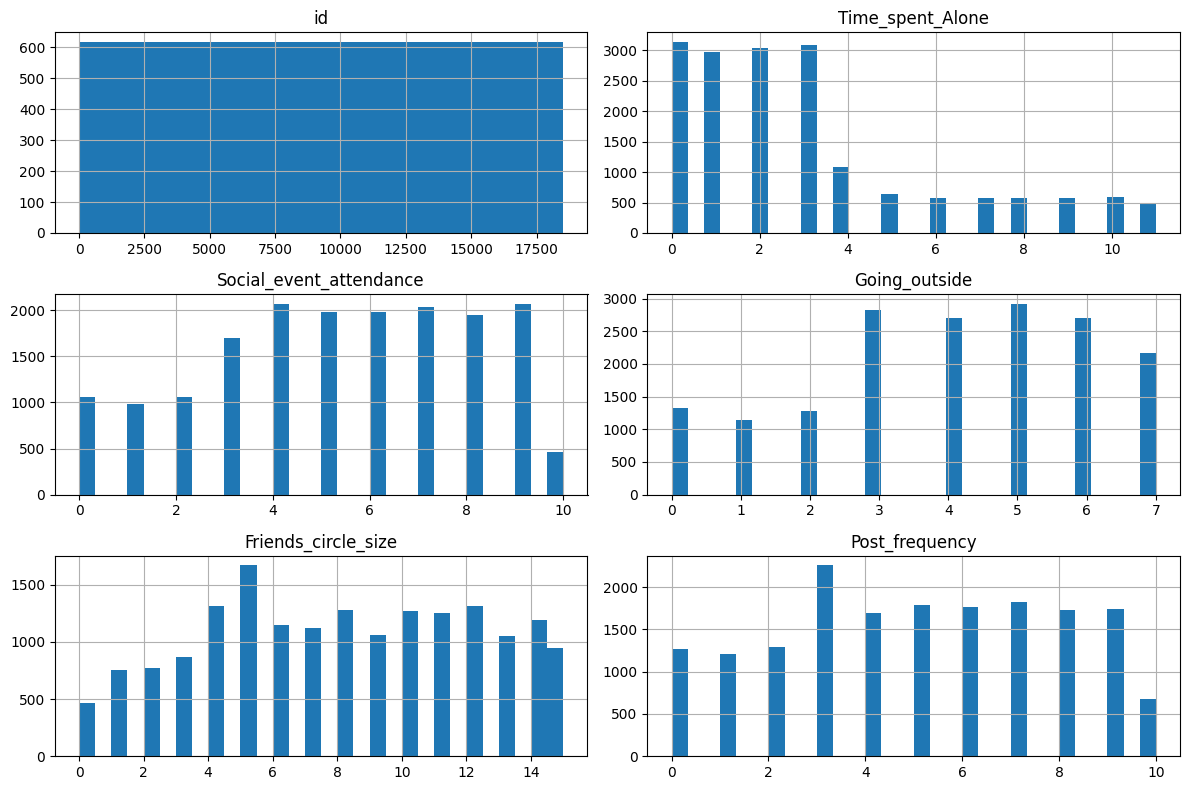

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

X.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

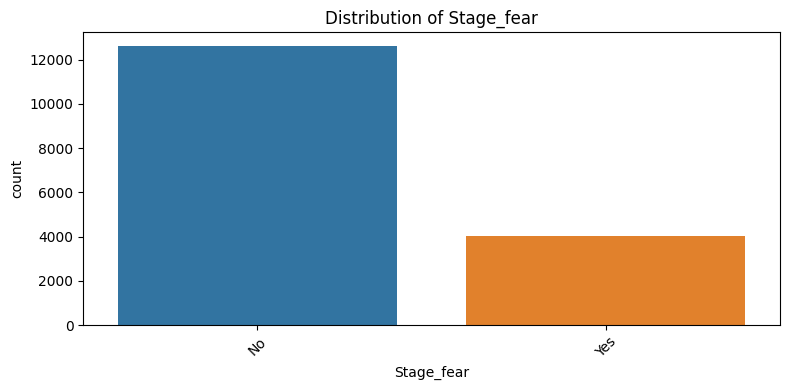

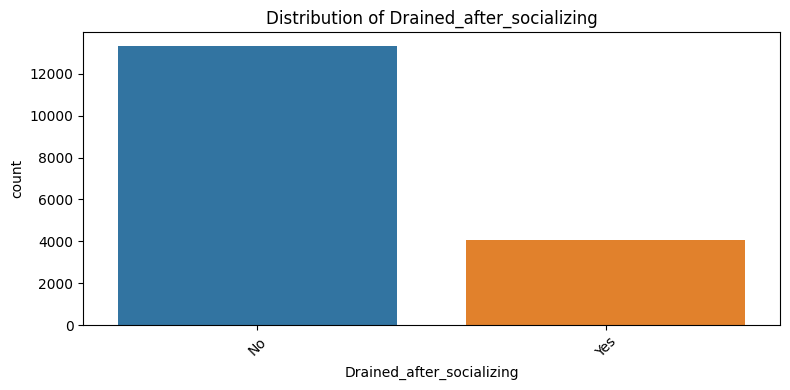

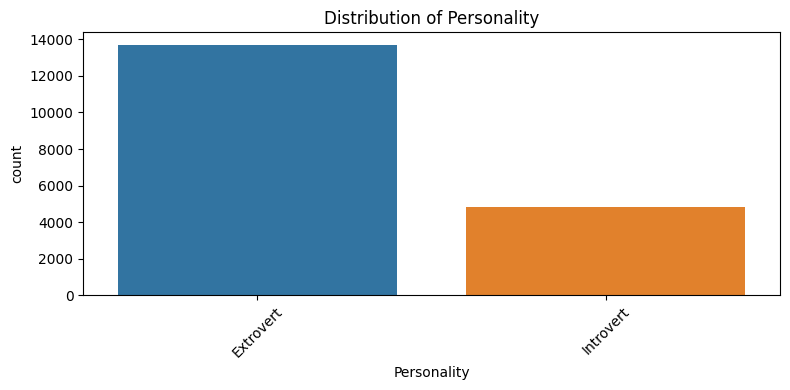

In [6]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=X, order=X[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Correlation matrix

<Axes: >

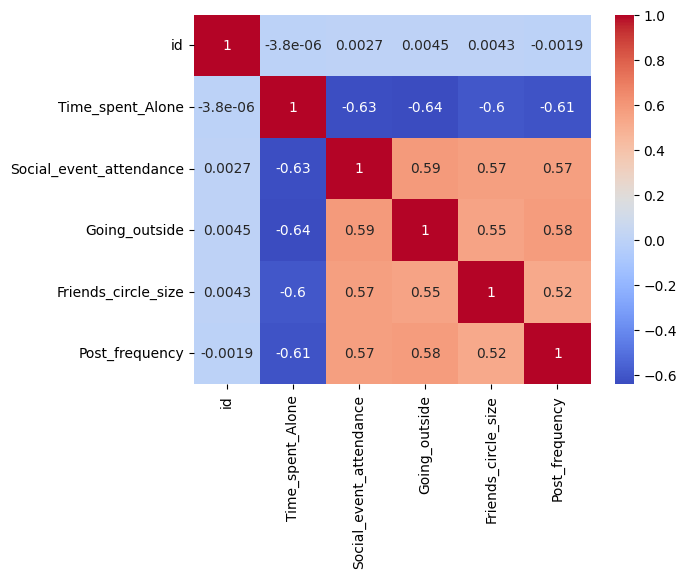

In [7]:
X_num = X.select_dtypes(include=['number']) # Includes all columns with numeric data types (int, float, etc.)

corr_matrix = X_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Removal of missing values and outliers

Filling every missing value with its mode

In [8]:
for col in X.columns:
    mode_val = X[col].mode()
    # print(mode_val)
    if not mode_val.empty:
        # X[col].fillna(mode_val[0], inplace=True) # This will change in pandas 3.0
        X[col] = X[col].fillna(mode_val[0])

print(X.isna().sum())

for col in y.columns:
    mode_val = y[col].mode()

    if not mode_val.empty:
        y[col] = y[col].fillna(mode_val[0])

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


In [9]:
numerical_cols_X = X.select_dtypes(include=['number']).columns
numerical_cols_y = y.select_dtypes(include=['number']).columns

for col in numerical_cols_X:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X = X[(X[col] >= lower_bound) & (X[col] <= upper_bound)]

for col in numerical_cols_y:
    Q1 = y[col].quantile(0.25)
    Q3 = y[col].quantile(0.75)
    IQR = Q3 - Q1 

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    y = y[(y[col] >= lower_bound) & (y[col] <= upper_bound)]

# Data preprocessing

Replacing categorical values with either 1 or 0

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = X.select_dtypes(include=['object', 'category']).columns 

le = LabelEncoder()

for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [11]:
categorical_cols = y.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    y[col] = le.fit_transform(y[col])

y.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,0,7.0,4.0,0,6.0,3.0
1,18525,0.0,1,0.0,0.0,1,5.0,1.0
2,18526,3.0,0,5.0,6.0,0,15.0,9.0
3,18527,3.0,0,4.0,4.0,0,5.0,6.0
5,18529,2.0,0,5.0,3.0,0,10.0,4.0
